In [1]:
# Libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm
import time
import numpy as np

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Dataset

In [2]:
df = pd.read_csv('data/qqp/train_v1.csv', header=0, index_col=0)
df['question'] = (df['question1'] + "|||" + df['question2'])
df = df[['is_duplicate', 'question']]
df

,is_duplicate,question
0,0,What is the total number of MBBS seats availab...
1,0,What are the difference between the hard drive...
2,0,Does IQ increase with age?|||I got glasses aro...
3,0,How did caterpillars evolve to digest themselv...
4,0,My brother had hemorrhage on his right brain a...
...,...,...
404282,1,What's the best thing to do in Goa?|||What is ...
404283,0,Can we write in our own words in IPCC theory s...
404284,1,What is an aristocracy?|||What is aristocracy?
404285,0,How does Stripes compare to Spring MVC?|||Whic...


In [3]:
df[df.is_duplicate == 1].shape[0]

149263

In [4]:
df[df.is_duplicate == 0].shape[0]

255024

In [5]:
destination_folder = 'logs/qqp'
source_folder = 'data/qqp'

In [6]:
eval_rate = 0.2
eval_index = int(df.shape[0] * eval_rate)

train_df = df[eval_index:].reset_index(drop=True)
eval_df = df[:eval_index].reset_index(drop=True)


os.makedirs(source_folder, exist_ok=True)

train_df.to_csv(f'{source_folder}/train_bert.csv', index=False)
eval_df.to_csv(f'{source_folder}/eval_bert.csv', index=False)

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 64
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)



label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)

text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('is_duplicate', label_field), ('question', text_field)]

# TabularDataset

train, valid = TabularDataset.splits(path=source_folder, train='train_bert.csv', validation='eval_bert.csv',
                                           format='CSV', fields=fields, skip_header=True)



# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.question),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.question),
                            device=device, train=True, sort=True, sort_within_batch=True)

## BERT

In [10]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [11]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [12]:
# Training Function

def train_model(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter),
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    running_step = 0
    valid_running_loss = 0.0
    valid_running_step = 0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        print(f'---> epoch {epoch+1} <---')
        
        
        time.sleep(0.5)
        loader = tqdm(train_loader, postfix={'Epoch': epoch+1})
        model.train()
        
        for (labels, text), _ in loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1
            running_step += 1
            
            loader.set_postfix({
                'Epoch': epoch+1,
                'Train loss': running_loss / running_step,
            }, refresh=True)
            
            
        # evaluation step
        time.sleep(0.5)
        loader = tqdm(valid_loader, postfix={'Epoch': epoch + 1,}, colour='green')
        
        model.eval()
        with torch.no_grad():
            label_preds = []
            # validation loop
            for (labels, text), _ in loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)
                loss, label_pred = output

                valid_running_loss += loss.item()
                valid_running_step += 1

                label_preds.extend((torch.argmax(label_pred, dim=1) == labels).cpu().numpy() * 1)

                loader.set_postfix({
                    'Epoch': epoch+1,
                    'Valid loss': valid_running_loss / valid_running_step,
                    'Valid score': np.mean(label_preds)
                }, refresh=True)

        # evaluation
        average_train_loss = running_loss / eval_every
        average_valid_loss = valid_running_loss / len(valid_loader)
        train_loss_list.append(average_train_loss)
        valid_loss_list.append(average_valid_loss)
        global_steps_list.append(global_step)

        # resetting running values
        running_loss = 0.0          
        running_step = 0

        valid_running_loss = 0.0
        valid_running_step = 0



        # print progress
        time.sleep(0.5)
        
        loader.write('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
              .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                      average_train_loss, average_valid_loss))

        # checkpoint
        if best_valid_loss > average_valid_loss:
            best_valid_loss = average_valid_loss
            save_checkpoint(file_path + '/' + 'model_bert.pt', model, best_valid_loss)
            save_metrics(file_path + '/' + 'metrics_bert.pt', train_loss_list, valid_loss_list, global_steps_list)

            loader.write('*** save ***')

        time.sleep(0.5)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    print('Finished Training!')

In [13]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [14]:
train_model(model=model, optimizer=optimizer)

---> epoch 1 <---


100%|██████████| 5054/5054 [05:54<00:00, 14.28it/s, Epoch=1, Valid loss=0.336, Valid score=0.854]


Epoch [1/5], Step [20215/101075], Train Loss: 0.2979, Valid Loss: 0.3361
Model saved to ==> logs/qqp/model_bert.pt
Model saved to ==> logs/qqp/metrics_bert.pt
*** save ***
---> epoch 2 <---


100%|██████████| 5054/5054 [05:55<00:00, 14.22it/s, Epoch=2, Valid loss=0.282, Valid score=0.883]


Epoch [2/5], Step [40430/101075], Train Loss: 0.1976, Valid Loss: 0.2825
Model saved to ==> logs/qqp/model_bert.pt
Model saved to ==> logs/qqp/metrics_bert.pt
*** save ***
---> epoch 3 <---


100%|██████████| 5054/5054 [05:25<00:00, 15.52it/s, Epoch=3, Valid loss=0.311, Valid score=0.888]


Epoch [3/5], Step [60645/101075], Train Loss: 0.1337, Valid Loss: 0.3107
---> epoch 4 <---


100%|██████████| 5054/5054 [05:24<00:00, 15.56it/s, Epoch=4, Valid loss=0.333, Valid score=0.895]


Epoch [4/5], Step [80860/101075], Train Loss: 0.0981, Valid Loss: 0.3332
---> epoch 5 <---


100%|██████████| 5054/5054 [05:25<00:00, 15.54it/s, Epoch=5, Valid loss=0.341, Valid score=0.899]


Epoch [5/5], Step [101075/101075], Train Loss: 0.0769, Valid Loss: 0.3409
Model saved to ==> logs/qqp/metrics.pt
Finished Training!


In [18]:
save_checkpoint(destination_folder + '/' + 'model_bert_final.pt', model, None)

Model saved to ==> logs/qqp/model_bert_final.pt


In [15]:

# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, text), _ in test_loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
best_model = BERT().to(device)

Model loaded from <== logs/qqp/model_bert.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8767    0.7944    0.8335     29785
           0     0.8863    0.9348    0.9099     51072

    accuracy                         0.8831     80857
   macro avg     0.8815    0.8646    0.8717     80857
weighted avg     0.8828    0.8831    0.8818     80857



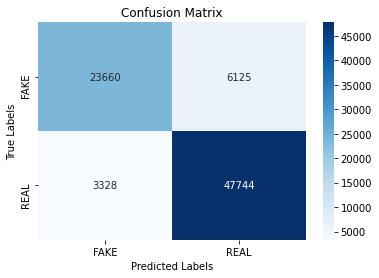

In [16]:
load_checkpoint(destination_folder + '/model_bert.pt', best_model)

evaluate(best_model, valid_iter)

In [49]:
def test_model(model, question1, question2):
    question = torch.tensor(tokenizer.encode(question1 + '|||' + question2), dtype=torch.long, device=device).unsqueeze(0)
    label = torch.tensor(0, dtype=torch.long, device=device).unsqueeze(0)
    _, output = model(question, label)
    output = output.argmax(dim=1)
    return output.item() == 1

In [61]:
question1 = 'Do you live in Paris?'
question2 = 'Do you stay in Paris?'
test_model(best_model, question1, question2)

True

In [67]:
question1 = 'Do you live in Paris?'
question2 = 'Do you live in Montréal?'
test_model(best_model, question1, question2)

False